#  EXERCISE 3 :

### Implement a sentiment analysis model with ScaledDotProduct attention mechanism using PyTorch .


### Train the model using the given dataset and evaluate its performance on the test data.

## *****START TO SENTIMENTAL ANALYSIS *******

##  1.Data Preparation

###  1.  Import Necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

### 2. Load dataset and  Handle Missing Values

In [2]:
# Load the dataset
data = pd.read_csv('5. Tweets.csv', sep=',')  # Dataset path

# Preprocess the data (basic cleaning)
data = data.dropna(subset=["text", "airline_sentiment"])  # Remove rows with missing data
data.shape

(14640, 15)

In [3]:
data[["text","airline_sentiment"]][:3]   #Print the text and sentiment in dataset

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral


### 3. Tokenization and assign word indicies

In [4]:
# Tokenization function
def simple_tokenize(text):
    return text.lower().split()    # convert the text into lower case and split words by space

# Convert text to sequences (tokenized indices)
word_to_index = {}        # store the word with its index form in key value pair i.e., dictionary
tokenized_texts = []      # empty array for  tokenized text
for text in data["text"]:
    tokens = simple_tokenize(text)
    tokenized_texts.append(tokens)
    for token in tokens:
        if token not in word_to_index:
            word_to_index[token] = len(word_to_index) + 1  # Index starts at 1
print(word_to_index[token])

897


In [5]:
print("A tokenized_text at an index:" ,tokenized_texts[0],"\n") # print the Tokens in a text
print("A tokenized words in all text with a assigned number:",list(word_to_index.items())[:100],"\n")  # print the word and index
print("Created Corpus with vocab_size :",len(word_to_index))  # print the word and index

A tokenized_text at an index: ['@virginamerica', 'what', '@dhepburn', 'said.'] 

A tokenized words in all text with a assigned number: [('@virginamerica', 1), ('what', 2), ('@dhepburn', 3), ('said.', 4), ('plus', 5), ("you've", 6), ('added', 7), ('commercials', 8), ('to', 9), ('the', 10), ('experience...', 11), ('tacky.', 12), ('i', 13), ("didn't", 14), ('today...', 15), ('must', 16), ('mean', 17), ('need', 18), ('take', 19), ('another', 20), ('trip!', 21), ("it's", 22), ('really', 23), ('aggressive', 24), ('blast', 25), ('obnoxious', 26), ('"entertainment"', 27), ('in', 28), ('your', 29), ("guests'", 30), ('faces', 31), ('&amp;', 32), ('they', 33), ('have', 34), ('little', 35), ('recourse', 36), ('and', 37), ('a', 38), ('big', 39), ('bad', 40), ('thing', 41), ('about', 42), ('it', 43), ('seriously', 44), ('would', 45), ('pay', 46), ('$30', 47), ('flight', 48), ('for', 49), ('seats', 50), ('that', 51), ('this', 52), ('playing.', 53), ('only', 54), ('flying', 55), ('va', 56), ('yes,', 5

### 4.Convert tokenized texts to integer sequences

In [6]:
# Convert tokenized texts to integer sequences
max_len = max([len(tokens) for tokens in tokenized_texts])  # Find max sentence length

sequences = []
for tokens in tokenized_texts:
    sequence = [word_to_index.get(token, 0) for token in tokens]  # Map tokens to indices
    sequences.append(sequence)

# Pad sequences to the same length
padded_sequences = np.array([seq + [0] * (max_len - len(seq)) for seq in sequences])

In [7]:
print("\n max length sentence :", max_len)
print("\n sample tokenized_texts :",tokenized_texts[4])
print("\n sample sequence :\n ",sequences[4])
print("\n sample padded sequence of size max length:\n",padded_sequences[4])


 max length sentence : 36

 sample tokenized_texts : ['@virginamerica', 'and', "it's", 'a', 'really', 'big', 'bad', 'thing', 'about', 'it']

 sample sequence :
  [1, 37, 22, 38, 23, 39, 40, 41, 42, 43]

 sample padded sequence of size max length:
 [ 1 37 22 38 23 39 40 41 42 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


# Test Case 1 Check if sequences are padded correctly

In [8]:
# TEST : Check if sequences are padded correctly
def test_padding(padded_sequences):
    assert padded_sequences.shape[1] == max_len, "Padding did not work correctly. Sequence length mismatch."
    assert all(len(seq) == max_len for seq in padded_sequences), "Not all sequences are padded to the same length."
test_padding(padded_sequences)

print("Test Case 1 Passed")

Test Case 1 Passed


### 5. Perform mapping target  to labels 

You are working with a dataset containing a column called airline_sentiment, which indicates the sentiment of airline reviews. The sentiment values are categorized as positive, neutral, and negative. Your task is to:

1. Map the sentiment categories to numerical labels using the following mapping:

    positive → 2
    neutral → 1
    negative → 0
    
   Store the mapped values as a NumPy array in the variable labels.


    

In [9]:
###BEGIN SOLUTION
# Prepare labels (sentiment)
labels = data["airline_sentiment"].map({"positive": 2, "neutral": 1, "negative": 0}).values
###END SOLUTION
print("airline_sentiment category at an index:", data["airline_sentiment"][2])
print("Converted airline_sentiment category to label at an index:",labels [2]) 

airline_sentiment category at an index: neutral
Converted airline_sentiment category to label at an index: 1


## 6. Converting X,y to Long tensors  ; Train-test split and creating data loaders

In [10]:
# Convert to tensors
X = torch.tensor(padded_sequences, dtype=torch.long)  # convert the padded sequence to long tensor 
y = torch.tensor(labels, dtype=torch.long)            # convert the label to long tensor

print("X at an index:", X[2])
print("y at an index:",y[2])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
#
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # batches of train or test data
test_loader = DataLoader(test_dataset, batch_size=64)

X at an index: tensor([ 1, 13, 14, 15, 16, 17, 13, 18,  9, 19, 20, 21,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
y at an index: tensor(1)


In [11]:
print(" length of train_dataset :",len(train_dataset))
print(" length of train_dataset  at an index :",train_dataset[0])
print(" length of test_dataset :",len(test_dataset))
print(" length of train_loader :",len(train_loader)) 
print(" length of test_loader :",len(test_loader))

 length of train_dataset : 11712
 length of train_dataset  at an index : (tensor([1163,   94,  191, 3472,  491, 1196, 3473,   49, 2327,  764,  257,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), tensor(0))
 length of test_dataset : 2928
 length of train_loader : 183
 length of test_loader : 46


## 2.Model Building

### 7.Define the scaled dot-product attention mechanism

You are tasked with implementing a Scaled Dot-Product Attention Mechanism, which is a core component of transformer-based models used in natural language processing. The attention mechanism helps the model focus on relevant parts of the input sequence. Your specific tasks are as follows:

1.Create a PyTorch module for Scaled Dot-Product Attention by defining a class ScaledDotAttention that inherits from torch.nn.Module.

2.Implement the constructor (__init__) method, which should:
    Accept a parameter hidden_size to define the size of attention embeddings.
    Store this value for later use.

3.Implement the forward pass (forward method) to:
    Take three input tensors: Q (query), K (key), and V (value).
    Compute the attention scores using the scaled dot-product formula given below:


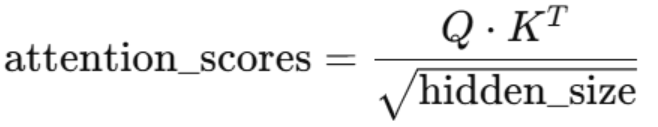


4.Apply the softmax function along the last dimension to obtain attention weights.
    Compute the final output by performing a weighted sum of the values (V) using the attention weights.
    Store the last inputs (Q, K, V) for debugging purposes.

5.Return the final attention output.

In [12]:
# Define the scaled dot-product attention mechanism
class ScaledDotAttention(nn.Module):   #inherit the pytorch nn.module to the mechanism class
    def __init__(self, hidden_size):   #Instantiate objects in the constructor
        super(ScaledDotAttention, self).__init__() # inherit the scaleddotproduct
        self.hidden_size = hidden_size

    def forward(self, Q, K, V):      # method for forward pass of Scaleddotproduct class
        # Compute scaled dot-product attention scores
        attention_scores = torch.matmul(Q, K.transpose(1, 2)) / np.sqrt(self.hidden_size)
        attention_weights = torch.softmax(attention_scores, dim=-1)
        output = torch.matmul(attention_weights, V)

        # Store values for debugging
        self.last_Q = Q
        self.last_K = K
        self.last_V = V

        return output

# Test Case 2 Check ScaledDotAttention

In [13]:
# Define the test case for ScaledDotAttention
def test_scaled_dot_attention():
    # Initialize the attention layer with a hidden size (e.g., 128)
    hidden_size = 128
    attention_layer = ScaledDotAttention(hidden_size)
    
    # Create dummy Q, K, and V tensors for the test
    batch_size = 2
    seq_len = 4
    feature_size = hidden_size
    Q = torch.randn(batch_size, seq_len, feature_size)  # Query tensor
    K = torch.randn(batch_size, seq_len, feature_size)  # Key tensor
    V = torch.randn(batch_size, seq_len, feature_size)  # Value tensor

    # Perform the forward pass
    output = attention_layer(Q, K, V)

    # Assert that the output shape is correct: (batch_size, seq_len, feature_size)
    assert output.shape == (batch_size, seq_len, feature_size), f"Expected output shape (batch_size, seq_len, feature_size), but got {output.shape}"

    # Print the output for verification
    print(" Test case 2 Passed!", output.shape)

# Run the test case
test_scaled_dot_attention()

 Test case 2 Passed! torch.Size([2, 4, 128])


### 8.Define the sentiment analysis model with scaled dot-product attention

In [14]:
# Define the sentiment analysis model with scaled dot-product attention
class SentimentAnalysisModel(nn.Module):  # inherit  SAModel from  nn.module
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(SentimentAnalysisModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.attention = ScaledDotAttention(hidden_size)
        self.fc = nn.Linear(hidden_size, 3)  # 3 classes: positive, neutral, negative

    def forward(self, x):
        embedded = self.embedding(x) 
        print("embedded",embedded.shape)
        #(batch_size, sequence_length, embedding_dim)
        lstm_out, (h_n, c_n) = self.lstm(embedded)  # shape(batch_size, sequence_length, hidden_size) ; Hidden state ,# cell state
        print("lstm_out",lstm_out.shape)
        # Apply scaled dot-product attention
        attention_out = self.attention(lstm_out, lstm_out, lstm_out)  # Q, K, V are lstm_out
        print("attention_out",attention_out.shape)
        out = attention_out[:, -1, :]  # Get the output of the last time step
        out = self.fc(out)
        return out
    

# Test Case 3 Check SentimentAnalysisModel 

In [15]:
# Define the test case for SentimentAnalysisModel
def test_sentiment_analysis_model():
    # Initialize the model with vocab_size, embedding_dim, and hidden_size
    vocab_size = 5000  # Example vocab size
    embedding_dim = 100
    hidden_size = 128
    model = SentimentAnalysisModel(vocab_size, embedding_dim, hidden_size)

    # Create dummy input data (e.g., batch size = 2, sequence length = 5)
    batch_size = 2
    seq_len = 5
    dummy_input = torch.randint(0, vocab_size, (batch_size, seq_len))  # Random token indices

    # Perform a forward pass
    output = model(dummy_input)


    # Check the shapes of intermediate outputs
    # Extract embeddings, LSTM outputs, and attention outputs from the model
    embedded = model.embedding(dummy_input)
    lstm_out, (h_n, c_n) = model.lstm(embedded)
    attention_out = model.attention(lstm_out, lstm_out, lstm_out)
    
    assert attention_out.shape == torch.Size([batch_size, seq_len, hidden_size]), \
        f"Expected attention_out shape (batch_size, seq_len, hidden_size), but got {attention_out.shape}"

    # Print the output shapes
    
    print(f"Final output: {output.shape}")
    print("Test Case 3 Passed!")

# Run the test case
test_sentiment_analysis_model()

embedded torch.Size([2, 5, 100])
lstm_out torch.Size([2, 5, 128])
attention_out torch.Size([2, 5, 128])
Final output: torch.Size([2, 3])
Test Case 3 Passed!


### 9.Initialize  model parameters , model,loss and optimizer

In [16]:
# For reference
vocab_size = len(word_to_index) + 1  # Include padding token
embedding_dim = 100
hidden_size = 128

print("Total unique word indexs: ", len(word_to_index))
print("Total unique words: ",vocab_size)

###BEGIN SOLUTION
# Instantiate a model variable with SentimentAnalysisModel
model = SentimentAnalysisModel(vocab_size, embedding_dim, hidden_size)

# Define loss  and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
###END SOLUTION

Total unique word indexs:  26840
Total unique words:  26841


### 5.Train the sentiment analysis model

In [17]:
# Training loop
def train_model(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss, total_acc = 0, 0

        print(f"Epoch {epoch+1}/{epochs}")

        for batch_idx, (inputs, labels) in enumerate(train_loader):

            # Forward pass
            outputs = model(inputs)       #
            loss = criterion(outputs, labels)  # calculates the cross entropy b/n label and predicted label

            # Backward pass
            optimizer.zero_grad()  # initalize the gradients to zero
            loss.backward()   # backpropagate
            optimizer.step()  # update the gradients

            total_loss += loss.item()
            total_acc += (outputs.argmax(1) == labels).sum().item()

            # Print Q, K, V for the first batch of the epoch
            if batch_idx == 0:
                attention_layer = model.attention
                Q, K, V = attention_layer.last_Q, attention_layer.last_K, attention_layer.last_V
                print(f"Q shape: {Q.shape}")
                print(f"K shape: {K.shape}")
                print(f"V shape: {V.shape}")

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_acc / len(train_loader.dataset)

        print(f"Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

        # Validation
        model.eval()  # model eval
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_acc += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Test Case 4 Checking Output Shape

In [18]:
# Create dummy dataset for testing
def create_dummy_dataset(batch_size=64, seq_len=5, vocab_size=5000, num_samples=1000):
    X = torch.randint(0, vocab_size, (num_samples, seq_len))
    y = torch.randint(0, 3, (num_samples,))  # 3 classes: 0, 1, 2
    dataset = TensorDataset(X, y)
    return dataset

# Define the test case for training loop
def test_train_model():
    # Initialize model, criterion, and optimizer
    vocab_size = 5000
    embedding_dim = 100
    hidden_size = 128
    model = SentimentAnalysisModel(vocab_size, embedding_dim, hidden_size)

    # Create dummy data
    train_dataset = create_dummy_dataset()
    val_dataset = create_dummy_dataset()
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model for a few epochs (e.g., 2 epochs for testing)
    epochs = 2
    train_model(model, train_loader, val_loader, epochs)


    # Ensure the output shape of the model is correct after forward pass
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        assert outputs.shape == (inputs.shape[0], 3), f"Expected output shape (batch_size, 3), but got {outputs.shape}"

        # Check gradients for the parameters to ensure backpropagation is working
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        if batch_idx >= 2:  # Run a few batches and then break
            break

    print(" Test Case 4 Passed:")

# Run the test case
test_train_model()


Epoch 1/2
embedded torch.Size([64, 5, 100])
lstm_out torch.Size([64, 5, 128])
attention_out torch.Size([64, 5, 128])
Q shape: torch.Size([64, 5, 128])
K shape: torch.Size([64, 5, 128])
V shape: torch.Size([64, 5, 128])
embedded torch.Size([64, 5, 100])
lstm_out torch.Size([64, 5, 128])
attention_out torch.Size([64, 5, 128])
embedded torch.Size([64, 5, 100])
lstm_out torch.Size([64, 5, 128])
attention_out torch.Size([64, 5, 128])
embedded torch.Size([64, 5, 100])
lstm_out torch.Size([64, 5, 128])
attention_out torch.Size([64, 5, 128])
embedded torch.Size([64, 5, 100])
lstm_out torch.Size([64, 5, 128])
attention_out torch.Size([64, 5, 128])
embedded torch.Size([64, 5, 100])
lstm_out torch.Size([64, 5, 128])
attention_out torch.Size([64, 5, 128])
embedded torch.Size([64, 5, 100])
lstm_out torch.Size([64, 5, 128])
attention_out torch.Size([64, 5, 128])
embedded torch.Size([64, 5, 100])
lstm_out torch.Size([64, 5, 128])
attention_out torch.Size([64, 5, 128])
embedded torch.Size([64, 5, 100]

[NVSHARE][WARN]: Couldn't open file /var/run/secrets/kubernetes.io/serviceaccount/namespace to read Pod namespace
[NVSHARE][INFO]: Successfully initialized nvshare GPU
[NVSHARE][INFO]: Client ID = 6fd9523608f8d11c


## 3:  Evaluate the Model

In [19]:
# Train the model
epochs = 5
train_model(model, train_loader, test_loader, epochs)
###BEGIN SOLUTION
# Evaluate the model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
###END SOLUTION
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/5
embedded torch.Size([64, 36, 100])
lstm_out torch.Size([64, 36, 128])
attention_out torch.Size([64, 36, 128])
Q shape: torch.Size([64, 36, 128])
K shape: torch.Size([64, 36, 128])
V shape: torch.Size([64, 36, 128])
embedded torch.Size([64, 36, 100])
lstm_out torch.Size([64, 36, 128])
attention_out torch.Size([64, 36, 128])
embedded torch.Size([64, 36, 100])
lstm_out torch.Size([64, 36, 128])
attention_out torch.Size([64, 36, 128])
embedded torch.Size([64, 36, 100])
lstm_out torch.Size([64, 36, 128])
attention_out torch.Size([64, 36, 128])
embedded torch.Size([64, 36, 100])
lstm_out torch.Size([64, 36, 128])
attention_out torch.Size([64, 36, 128])
embedded torch.Size([64, 36, 100])
lstm_out torch.Size([64, 36, 128])
attention_out torch.Size([64, 36, 128])
embedded torch.Size([64, 36, 100])
lstm_out torch.Size([64, 36, 128])
attention_out torch.Size([64, 36, 128])
embedded torch.Size([64, 36, 100])
lstm_out torch.Size([64, 36, 128])
attention_out torch.Size([64, 36, 128])
embed

## 4. Prediction on Unseen sample input

In [20]:
###BEGIN SOLUTION
def predict_sentiment(model, text, word_to_index):
    # Tokenize and convert words to indices
    text_indices = [[word_to_index.get(word, 0) for word in simple_tokenize(t)] for t in text]
    
    # Pad sequences to the longest sentence
    max_len = max(map(len, text_indices))
    text_indices = [seq + [0] * (max_len - len(seq)) for seq in text_indices]

    # Convert to tensor and predict
    text_tensor = torch.tensor(text_indices, dtype=torch.long)
    model.eval()
    with torch.no_grad():
        output = model(text_tensor)
    
    # Get predicted sentiment
    sentiment_labels = ["Neutral Comment", "Negative Comment", "Positive Comment"]
    return f"Predicted Sentiment: {sentiment_labels[output.argmax(dim=1).item()]}"
###END SOLUTION
# predict with three unseen text
t1 = ['Nothing special, but no complaints.']
t2 = ['I am too excited ']  # Very happy to hear you
t3 = ['Something went wrong']  # It's disappointing

# Choose text for prediction
unseen_text = t3 

# Call prediction function
result = predict_sentiment(model, unseen_text , word_to_index)
print(result)

embedded torch.Size([1, 3, 100])
lstm_out torch.Size([1, 3, 128])
attention_out torch.Size([1, 3, 128])
Predicted Sentiment: Neutral Comment
